In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
from growth import *
from utils import *
from smoother import *
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.special import ndtri
import warnings

In [2]:
import cvxpy
import clarabel
print("CVXPY:", cvxpy.__version__)
print("Clarabel:", clarabel.__version__)


CVXPY: 1.6.6
Clarabel: 0.11.1


In [3]:
def plot_gt(hrr_dfs, hrr_code, ref_names, date_seq, trim_length, gt_thr, cnt_thr, penalty_values, noise_models, zero_options, correction_indicators, interval_threshold):
    line_colors = [
        "#882255",  # Burgundy
        "#DDCC77",  # Soft mustard
        "#44AA99",  # Teal
    ]
    cnt_seqs = []
    for hrr_df in hrr_dfs:
        cnt_seq = np.array(hrr_df[hrr_code])
        cnt_seqs.append(cnt_seq)
        if all(cnt_seq <= cnt_thr):
            return None

    alt_date_list = []
    plt.figure(figsize=(10, 2))

    phi_shades = np.linspace(0.0, 0.6, num=len(penalty_values) * len(noise_models))  # Different shades of black
    shade_idx = 0
    all_scales = None  # To capture scales outside loop

    for lmbda in penalty_values:
        for m_idx, noise_model in enumerate(noise_models):
            phi, _, scales, _ = multi_smoother(
                cnt_seqs=cnt_seqs,
                date_seq=date_seq,
                lmbda_value=lmbda,
                noise_models=noise_model,
                zero_options=zero_options[m_idx],
                correction_indicators=correction_indicators
            )
            if all_scales is None:
                all_scales = scales  # Save scales from the first run
            # Plot phi with slightly different black shades
            gray_val = phi_shades[shade_idx]
            plt.plot(date_seq, phi, color=(gray_val, gray_val, gray_val), linewidth=2.0, zorder=3)
            shade_idx += 1

            null_indices, alt_indices = label_null_alt_dates(phi, gt_thr)
            alt_date_list.append(date_seq[alt_indices])

    # Plot cnt_seq with dashed lines and 50% opacity
    for c_idx, cnt_seq in enumerate(cnt_seqs):
        plt.plot(
            date_seq[trim_length:-trim_length],
            cnt_seq[trim_length:-trim_length] / all_scales[c_idx],
            label=ref_names[c_idx],
            color=line_colors[c_idx],
            alpha=0.5,
            linewidth=1.5,
            linestyle='--',
            zorder=2
        )

    consensus_alt = get_consensus_dates(alt_date_list)
    consensus_alt = consensus_alt[
        (consensus_alt > date_seq[trim_length]) &
        (consensus_alt < date_seq[-trim_length])
    ]
    consensus_alt_intervals = split_indices_into_intervals_threshold(consensus_alt, interval_threshold)
    for start, end in consensus_alt_intervals:
        plt.axvspan(start, end, color="#D55E00", alpha=0.2, zorder=1)

    plt.yticks([])
    plt.title(hrr_code)
    plt.legend()


CPRadmission 2021-01-07 00:00:00 2022-06-21 00:00:00
JHUcase 2021-01-07 00:00:00 2022-06-21 00:00:00
CHNGclaim 2021-01-07 00:00:00 2022-06-21 00:00:00


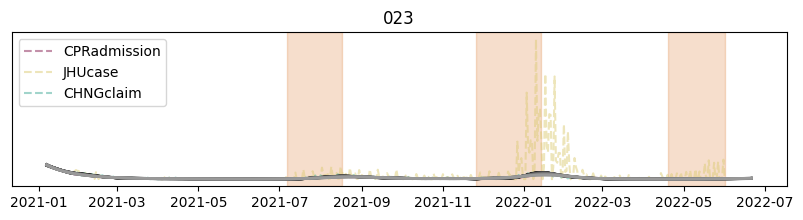

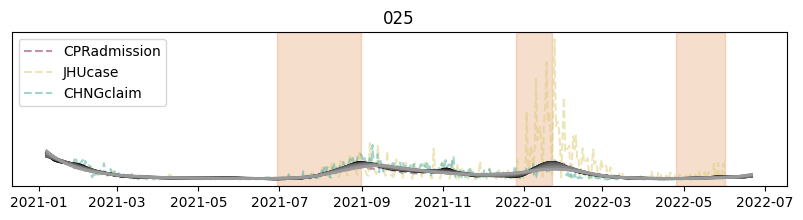

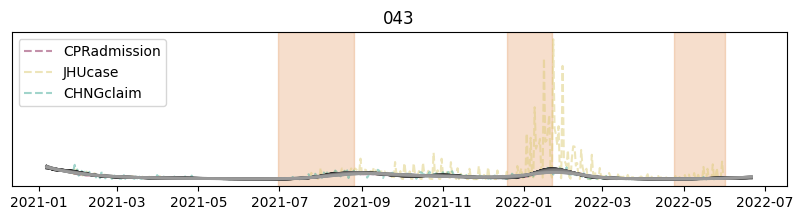

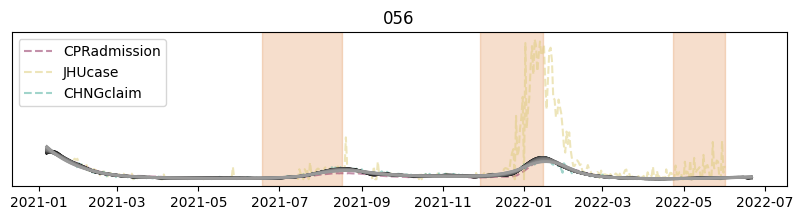

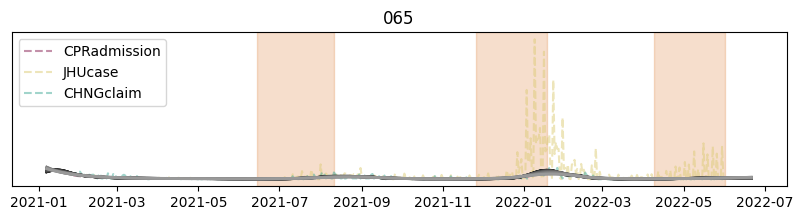

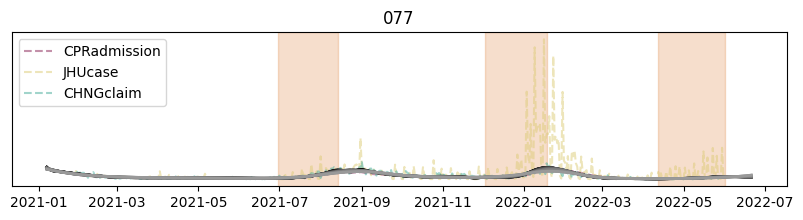

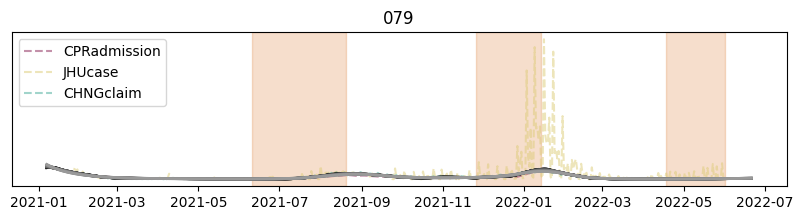

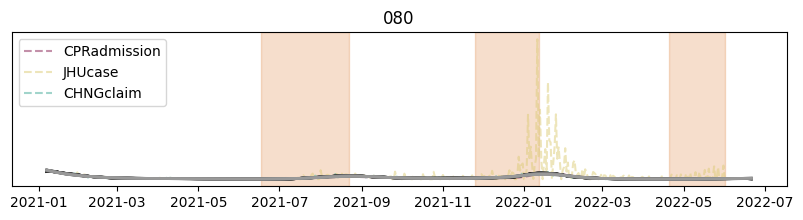

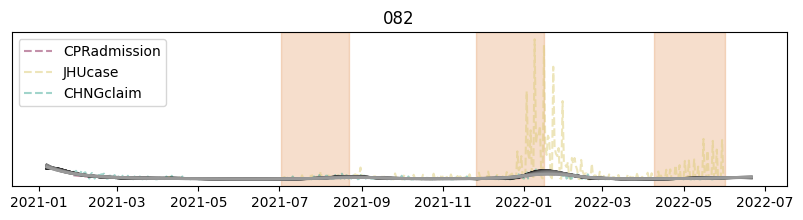

In [4]:
date_ref = pd.read_csv(f'data/CPRadmission/CA_HRR.csv', index_col=0)
date_ref.index = pd.to_datetime(date_ref.index, format='%Y-%m-%d')
date_seq = date_ref.index
len(date_seq)
warnings.filterwarnings('ignore')
cnt_thr = 20
trim_length = 20
gt_thr = 0.

ref_names = ['CPRadmission', 'JHUcase', 'CHNGclaim']
ref_dfs = [pd.read_csv(f'data/{data_name}/CA_HRR.csv', index_col=0) for data_name in ref_names]
for d_idx in range(len(ref_names)):
    ref_dfs[d_idx].index = pd.to_datetime(ref_dfs[d_idx].index, format='%Y-%m-%d')
    ref_dfs[d_idx] = ref_dfs[d_idx].loc[date_seq]
    print(ref_names[d_idx], ref_dfs[d_idx].index[0], ref_dfs[d_idx].index[-1])

noise_models = [['LogNormal', 'LogNormal', 'Poisson'], ['LogNormal', 'LogNormal', 'Poisson']]
penalty_values = [30, 100, 300, 1000, 3000, 10000, 30000]
zero_options = [['plus_one', 'plus_one', None], ['impute', 'impute', None]]
correction_indicators = [False, True, True]
for hrr_code in ref_dfs[0].columns:
    plot_gt(ref_dfs, hrr_code, ref_names, date_seq, trim_length, gt_thr, cnt_thr, penalty_values, noise_models, zero_options, correction_indicators, interval_threshold = 14)

In [5]:
date_ref = pd.read_csv(f'dataFU/CPRadmission/CA_HRR.csv', index_col=0)
date_ref.index = pd.to_datetime(date_ref.index, format='%Y-%m-%d')
date_seq = date_ref.index
len(date_seq)
warnings.filterwarnings('ignore')
cnt_thr = 20
trim_length = 20
gt_thr = 0.

ref_names = ['CPRadmission', 'JHUcase', 'CHNGclaim']
ref_dfs = [pd.read_csv(f'dataFU/{data_name}/ALL_HRR.csv', index_col=0) for data_name in ref_names]
for d_idx in range(len(ref_names)):
    ref_dfs[d_idx].index = pd.to_datetime(ref_dfs[d_idx].index, format='%Y-%m-%d')
    ref_dfs[d_idx] = ref_dfs[d_idx].loc[date_seq]
    print(ref_names[d_idx], ref_dfs[d_idx].index[0], ref_dfs[d_idx].index[-1])

noise_models = [['LogNormal', 'LogNormal', 'Poisson'], ['LogNormal', 'LogNormal', 'Poisson']]
penalty_values = [30, 100, 300, 1000, 3000, 10000, 30000]
zero_options = [['plus_one', 'plus_one', None], ['impute', 'impute', None]]
correction_indicators = [False, True, True]
consensus_nulls, consensus_alts, null_intervals, alt_intervals = construct_gt(ref_dfs, date_seq, trim_length, gt_thr, cnt_thr, penalty_values, noise_models, zero_options, correction_indicators, interval_threshold = 14)

CPRadmission 2021-01-07 00:00:00 2022-06-21 00:00:00
JHUcase 2021-01-07 00:00:00 2022-06-21 00:00:00
CHNGclaim 2021-01-07 00:00:00 2022-06-21 00:00:00


In [6]:
from matplotlib.animation import FuncAnimation
data_names = ['CPRadmission', 'JHUcase', 'CHNGclaim', 'doctorvisits', 'FBwtested', 'FBwhh', 'FBpositive', 'QUIDELpositive', 'FBwcli',
             'GoogleS03', 'GoogleS04', 'GoogleS05']
meta_method = 'Stouffer'
meta_lists = [['CPRadmission', 'JHUcase', 'CHNGclaim'],
              ['doctorvisits', 'GoogleS03', 'FBwtested', 'FBwhh', 'GoogleS05'],
              ['FBpositive', 'QUIDELpositive', 'FBwcli', 'GoogleS04']]
    
state = 'ALL'
real_dfs = [pd.read_csv(f'dataFU/{data_name}/{state}_HRR.csv', index_col=0) for data_name in data_names]
for d_idx in range(len(data_names)):
    real_dfs[d_idx].index = pd.to_datetime(real_dfs[d_idx].index, format='%Y-%m-%d')
    real_dfs[d_idx] = real_dfs[d_idx].loc[date_seq]
    print(data_names[d_idx], real_dfs[d_idx].index[0], real_dfs[d_idx].index[-1])
hrr_codes = [set(real_dfs[d_idx].columns) for d_idx in range(len(data_names))]
hrr_codes = set.intersection(*hrr_codes)
consensus_nulls_ = {hrr_code: consensus_nulls[hrr_code] for hrr_code in hrr_codes if hrr_code in consensus_nulls.keys()}
consensus_alts_ = {hrr_code: consensus_alts[hrr_code] for hrr_code in hrr_codes if hrr_code in consensus_alts.keys()}
alt_intervals_ = {hrr_code: alt_intervals[hrr_code] for hrr_code in hrr_codes if hrr_code in alt_intervals.keys()}
hrr_codes = list(sorted(consensus_nulls_.keys()))

q = 0.95
max_delay_days = 60
window_size = 21
cnt_thr = 0
print(f'alpha = {(1-q) * 100:.2f}%')
print(f"Window size {window_size}")
growth_rates_dfs = {}
growth_pvals_dfs = {}
first_exceedance_times_dict = {}
for h_idx, hrr_df in enumerate(real_dfs):
    growth_rates_df = compute_growth_rates_df(hrr_df, date_seq, window_size, regression_model = 'LogLinear', zero_option = 'impute', end_days_plus = window_size//2, seq_thr = 0)
    null_dist, alt_dist = construct_gt_dist(hrr_df, growth_rates_df, cnt_thr, consensus_nulls_, consensus_alts_)
    growth_pvals_df = pd.DataFrame(index=growth_rates_df.index, columns=hrr_codes)
    for column in hrr_codes:
        for index in growth_rates_df.index:
            try:
                growth_pvals_df.at[index, column] = np.mean(null_dist > growth_rates_df.at[index, column])
            except KeyError:
                growth_pvals_df.at[index, column] = np.nan
    growth_pvals_dfs[data_names[h_idx]] = growth_pvals_df.copy()
    growth_rates_dfs[data_names[h_idx]] = growth_rates_df.copy()
    p_null_dist, p_alt_dist = construct_dist(growth_pvals_df, consensus_nulls_, consensus_alts_)
    pvals_threshold = np.quantile(p_null_dist, 1-q)
    first_exceedance_times_dict[data_names[h_idx]] = {}
    for key, alt_interval in alt_intervals_.items():
        first_exceedance_times_dict[data_names[h_idx]][key] = []
        for start, end in alt_interval:
            interval_data = growth_pvals_df[key][start.strftime('%y-%m-%d'):end.strftime('%y-%m-%d')]
            exceeds_threshold = interval_data[interval_data < pvals_threshold]
            if not exceeds_threshold.empty:
                first_exceedance_time = pd.to_datetime(exceeds_threshold.index[0], format='%y-%m-%d')
                first_exceedance_times_dict[data_names[h_idx]][key].append((first_exceedance_time, start, (first_exceedance_time - start).days))
    
for m_idx, meta_list in enumerate(meta_lists): 
    growth_cnts_df = pd.DataFrame(index=growth_rates_df.index, columns=hrr_codes)
    for column in hrr_codes:
        for i, index in enumerate(growth_rates_df.index):
            # growths = [growth_rates_dfs[df_name][column][i] for df_name in meta_list]
            growths = []
            for df_name in meta_list:
                try:
                    growths.append(growth_rates_dfs[df_name][column][i])
                except KeyError:
                    growths.append(0)
            growth_cnts_df.at[index, column] = np.sum((np.array(growths)>0))
    c_null_dist, c_alt_dist = construct_dist(growth_cnts_df, consensus_nulls_, consensus_alts_)
    cnts_threshold = np.quantile(c_null_dist, q)
    first_exceedance_times_dict[f'{m_idx}_Stolerman'] = {}
    for key, alt_interval in alt_intervals_.items():
        first_exceedance_times_dict[f'{m_idx}_Stolerman'][key] = []
        for start, end in alt_interval:
            interval_data = growth_cnts_df[key][start.strftime('%y-%m-%d'):end.strftime('%y-%m-%d')]
            exceeds_threshold = interval_data[interval_data > cnts_threshold]
            if not exceeds_threshold.empty:
                first_exceedance_time = pd.to_datetime(exceeds_threshold.index[0], format='%y-%m-%d')
                first_exceedance_times_dict[f'{m_idx}_Stolerman'][key].append((first_exceedance_time, start, (first_exceedance_time - start).days))
                
for m_idx, meta_list in enumerate(meta_lists): 
    growth_pvals_df = pd.DataFrame(index=growth_rates_df.index, columns=hrr_codes)
    for column in hrr_codes:
        for index in growth_rates_df.index:
            pvals = np.array([growth_pvals_dfs[df_name].at[index, column] for df_name in meta_list])
            growth_pvals_df.at[index, column] = meta_pvals(pvals, meta_method)
    p_null_dist, p_alt_dist = construct_dist(growth_pvals_df, consensus_nulls_, consensus_alts_)
    pvals_threshold = np.quantile(p_null_dist, 1-q)
    first_exceedance_times_dict[f'{m_idx}_{meta_method}'] = {}
    delay_results = []
    for key, alt_interval in alt_intervals_.items():
        first_exceedance_times_dict[f'{m_idx}_{meta_method}'][key] = []
        for start, end in alt_interval:
            interval_data = growth_pvals_df[key][start.strftime('%y-%m-%d'):end.strftime('%y-%m-%d')]
            exceeds_threshold = interval_data[interval_data < pvals_threshold]
            if not exceeds_threshold.empty:
                first_exceedance_time = pd.to_datetime(exceeds_threshold.index[0], format='%y-%m-%d')
                first_exceedance_times_dict[f'{m_idx}_{meta_method}'][key].append((first_exceedance_time, start, (first_exceedance_time - start).days))

CPRadmission 2021-01-07 00:00:00 2022-06-21 00:00:00
JHUcase 2021-01-07 00:00:00 2022-06-21 00:00:00
CHNGclaim 2021-01-07 00:00:00 2022-06-21 00:00:00
doctorvisits 2021-01-07 00:00:00 2022-06-21 00:00:00
FBwtested 2021-01-07 00:00:00 2022-06-21 00:00:00
FBwhh 2021-01-07 00:00:00 2022-06-21 00:00:00
FBpositive 2021-01-07 00:00:00 2022-06-21 00:00:00
QUIDELpositive 2021-01-07 00:00:00 2022-06-21 00:00:00
FBwcli 2021-01-07 00:00:00 2022-06-21 00:00:00
GoogleS03 2021-01-07 00:00:00 2022-06-21 00:00:00
GoogleS04 2021-01-07 00:00:00 2022-06-21 00:00:00
GoogleS05 2021-01-07 00:00:00 2022-06-21 00:00:00
alpha = 5.00%
Window size 21


In [7]:
first_exceedance_times_dict.keys()

dict_keys(['CPRadmission', 'JHUcase', 'CHNGclaim', 'doctorvisits', 'FBwtested', 'FBwhh', 'FBpositive', 'QUIDELpositive', 'FBwcli', 'GoogleS03', 'GoogleS04', 'GoogleS05', '0_Stolerman', '1_Stolerman', '2_Stolerman', '0_Stouffer', '1_Stouffer', '2_Stouffer'])

In [53]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

def plot_gt(times_dict, hrr_dfs, hrr_code, ref_names, date_seq, trim_length,
            gt_thr, cnt_thr, penalty_values, noise_models,
            zero_options, correction_indicators, interval_threshold):

    """
        '1_Stouffer':        'LRTrend (GT)',
        '2_Stouffer':        'LRTrend (Medium)',
        '3_Stouffer':        'LRTrend (Weak)',
    
        '1_Stolerman':       'Stolerman (GT)',
        '2_Stolerman':       'Stolerman (Medium)',
        '3_Stolerman':       'Stolerman (Weak)',
    """
    method_names = {
    
        'CPRadmission':      'CPR Admissions',
        'doctorvisits':      'Doctor Visits',
        'GoogleS03':         'GoogleS03',
        'FBwtested':         'FBwtested',
    }
    
    # Unified color scheme
    method_colors = {
        '1_Stouffer':     '#d62728',  # red
        '2_Stouffer':     '#d62728',
        '3_Stouffer':     '#d62728',
    
        '1_Stolerman':    '#7f7f7f',  # gray
        '2_Stolerman':    '#7f7f7f',
        '3_Stolerman':    '#7f7f7f',


        # Ground Truth (GT) — red_shades
        'CPRadmission': 'gold',#'#8b0000',  # dark red
        'JHUcase':      'skyblue',#'#cc0000',  # medium red
        'CHNGclaim':    'green',#'#ff6666',  # light red
    
        # Medium Strength — blue_shades
        'doctorvisits': 'purple',  # darkest blue
        'GoogleS03':    "brown", #'#0066ff',  # dark blue
        'FBwtested':    '#3399ff',  # medium blue
        'FBwhh':        '#66ccff',  # light blue
        'GoogleS05':    '#99ddff',  # lightest blue
    
        # Weak Strength — purple_shades
        'FBpositive':     '#4b004b',  # dark purple
        'QUIDELpositive': '#660066',  # medium-dark purple
        'FBwcli':         '#993399',  # medium-light purple
        'GoogleS04':      '#cc66cc',  # light purple
    }

    # Shared marker shapes for 1/2/3 across both methods
    method_markers = {
        '1_Stouffer':     'o',
        '2_Stouffer':     '^',
        '3_Stouffer':     'X',
    
        '1_Stolerman':    'o',
        '2_Stolerman':    '^',
        '3_Stolerman':    'X',
    
        'CPRadmission':   'D',
        'doctorvisits':   's',
        'GoogleS03':      'v',
        'FBwtested':      'P',
    }


    # Load counts
    cnt_seqs = []
    for hrr_df in hrr_dfs:
        seq = np.array(hrr_df[hrr_code])
        if all(seq <= cnt_thr):
            return None
        cnt_seqs.append(seq)

    # Set up figure
    plt.figure(figsize=(7, 2.5))

    phi_shades = np.linspace(0.0, 0.6, num=len(penalty_values) * len(noise_models))
    shade_idx = 0
    all_scales = None
    alt_date_list = []

    for lam in penalty_values:
        for m_idx, noise_model in enumerate(noise_models):
            phi, _, scales, _ = multi_smoother(
                cnt_seqs=cnt_seqs,
                date_seq=date_seq,
                lmbda_value=lam,
                noise_models=noise_model,
                zero_options=zero_options[m_idx],
                correction_indicators=correction_indicators
            )
            if all_scales is None:
                all_scales = scales

            gray = phi_shades[shade_idx]
            plt.plot(
                date_seq, phi,
                color=(gray, gray, gray),
                linewidth=2.0,
                #linestyle='None',
                zorder=3
            )
            shade_idx += 1

            _, alt_i = label_null_alt_dates(phi, gt_thr)
            alt_date_list.append(date_seq[alt_i])

    # Plot reference signals
    if True:
        for idx, name in enumerate(ref_names):
            col = method_colors.get(name, '#444444')
            seq = cnt_seqs[idx]
            plt.plot(
                date_seq[trim_length:-trim_length],
                seq[trim_length:-trim_length] / all_scales[idx],
                label=name,
                color=col,
                alpha=0.8,
                linewidth=1.0,
                zorder=2
            )

    # Highlight retrospective intervals
    consensus = get_consensus_dates(alt_date_list)
    mask = (consensus > date_seq[trim_length]) & (consensus < date_seq[-trim_length])
    intervals = split_indices_into_intervals_threshold(consensus[mask], interval_threshold)
    for start, end in intervals:
        plt.axvspan(start, end, color="#D55E00", alpha=0.2, zorder=1)

    # Scatter alarm times
    ymin = 0
    ymax = max(max(cnt_seqs[0] / all_scales[0]),
               max(cnt_seqs[2] / all_scales[2])) * 1.3
    y_diff = ymax - ymin
    for m_idx, method in enumerate(method_names):
        pts = times_dict.get(method, {}).get(hrr_code, [])
        if not pts:
            continue
        times = [p[0] for p in pts]
        y_level = (0.9 - m_idx * 0.1) * y_diff
        plt.scatter(
            times,
            np.full(len(times), y_level),
            marker=method_markers[method],
            facecolor=method_colors[method],
            edgecolor='black',
            linewidth=1.0,
            s=80,
            label=f"{method_names[method]}",
            zorder=10
        )

    # Legends
    ax = plt.gca()

    # Legend 1: GT and Reference Lines
    line_legend_handles = [
        Line2D([0], [0], color='#2f2f2f', lw=2,  label='Ground truth'),
    #Patch(facecolor='#D55E00', alpha=0.2, label='Ground truth trend')  # NEW shaded box
    ]
    for name in ref_names:
        line_legend_handles.append(Line2D(
            [0], [0],
            color=method_colors.get(name, '#444444'),
            lw=1.0,
            alpha=0.8,
            label=method_names.get(name, name)
        ))
    legend1 = ax.legend(
        handles=line_legend_handles,
        title='Data streams',
        loc='upper left',
        bbox_to_anchor=(1.01, 1.0),
        frameon=True
    )
    ax.add_artist(legend1)

    # Legend 2: Alarm Markers
    marker_legend_handles = [
        Line2D(
            [0], [0],
            marker=method_markers[method],
            linestyle='None',
            markerfacecolor=method_colors[method],
            markeredgecolor='black',
            markeredgewidth=1.0,
            markersize=8,
            label=f"{method_names[method]}"
        ) for method in method_names
    ]
    
    legend2= ax.legend(
        handles=marker_legend_handles,
        title='Alarms',
        loc='upper left',
        bbox_to_anchor=(1.01, 0.25),
        frameon=True
    )
    
    ax.add_artist(legend2)
    
    plt.yticks([])
    plt.ylim(ymin, ymax)
    plt.title(hrr_code)

    plt.subplots_adjust(left=0.25)
    plt.tight_layout()
    if hrr_code == '082':
        plt.title('San Jose COVID-19 trends 2021-2022', fontsize=20)
        plt.savefig('univariate timescale.png', dpi=300, bbox_inches='tight')
    if hrr_code == '056':
        plt.title('Los Angeles COVID-19 trends 2021-2022', fontsize=16)
        plt.savefig(f'{hrr_code}_univariate_timescale.png', dpi=300, bbox_inches='tight')
    if hrr_code == '357':
        plt.title('Pittsburgh COVID-19 trends 2021-2022', fontsize=16)
        plt.savefig(f'{hrr_code}_univariate_timescale.png', dpi=300, bbox_inches='tight')
    if hrr_code == '356':
        plt.title('Philadelphia COVID-19 trends 2021-2022', fontsize=16)
        plt.savefig(f'{hrr_code}_univariate_timescale.png', dpi=300, bbox_inches='tight')
    if hrr_code == '391':
        plt.title('Dallas COVID-19 trends 2021-2022', fontsize=16)
        plt.savefig(f'{hrr_code}_univariate_timescale.png', dpi=300, bbox_inches='tight')
    if hrr_code == '397':
        plt.title('Houston COVID-19 trends 2021-2022', fontsize=16)
        plt.savefig(f'{hrr_code}_univariate_timescale.png', dpi=300, bbox_inches='tight')
    if hrr_code == '130':
        plt.title('Orlando COVID-19 trends 2021-2022', fontsize=16)
        plt.savefig(f'{hrr_code}_univariate_timescale.png', dpi=300, bbox_inches='tight')
    if hrr_code == '127':
        plt.title('Miami COVID-19 trends 2021-2022', fontsize=16)
        plt.savefig(f'{hrr_code}_univariate_timescale.png', dpi=300, bbox_inches='tight')
    if hrr_code == '303':
        plt.title('New York City COVID-19 trends 2021-2022', fontsize=16)
        plt.savefig(f'{hrr_code}_univariate_timescale.png', dpi=300, bbox_inches='tight')
    if hrr_code == '304':
        plt.title('Rochester COVID-19 trends 2021-2022', fontsize=16)
        plt.savefig(f'{hrr_code}_univariate_timescale.png', dpi=300, bbox_inches='tight')
    if hrr_code == '312':
        plt.title('Durham COVID-19 trends 2021-2022', fontsize=16)
        plt.savefig(f'{hrr_code}_univariate_timescale.png', dpi=300, bbox_inches='tight')
    if hrr_code == '227':
        plt.title('Boston COVID-19 trends 2021-2022', fontsize=16)
        plt.savefig(f'{hrr_code}_univariate_timescale.png', dpi=300, bbox_inches='tight')
    if hrr_code == '230':
        plt.title('Springfield COVID-19 trends 2021-2022', fontsize=16)
        plt.savefig(f'{hrr_code}_univariate_timescale.png', dpi=300, bbox_inches='tight')
    plt.show()


CPRadmission 2021-01-07 00:00:00 2022-06-21 00:00:00
JHUcase 2021-01-07 00:00:00 2022-06-21 00:00:00
CHNGclaim 2021-01-07 00:00:00 2022-06-21 00:00:00


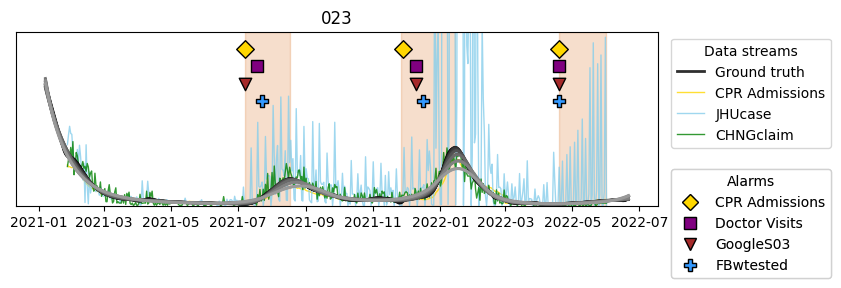

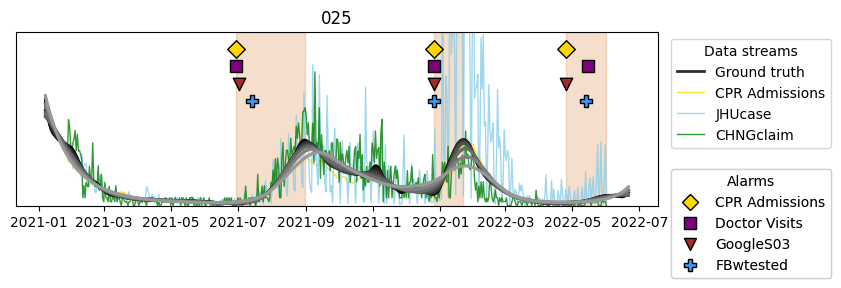

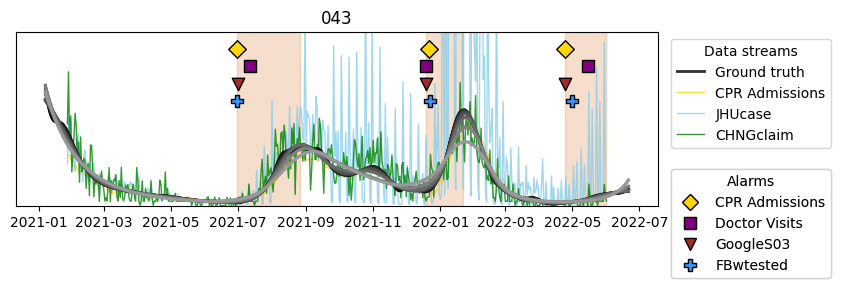

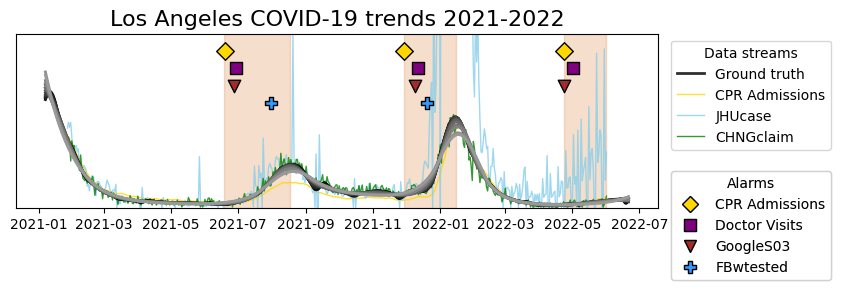

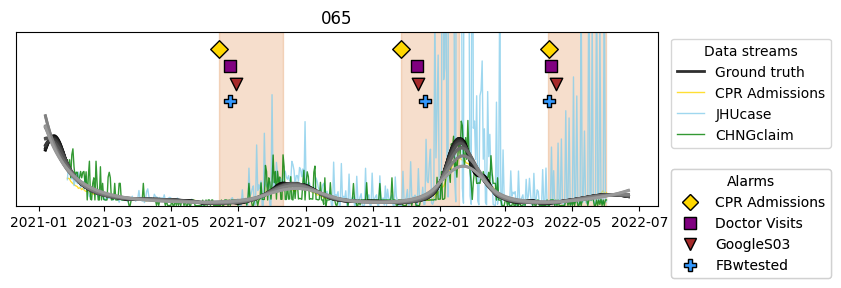

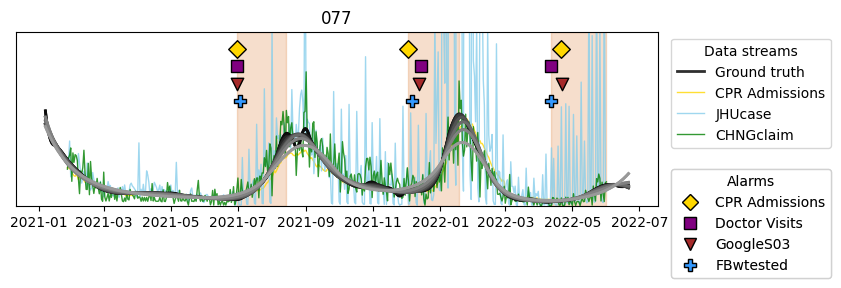

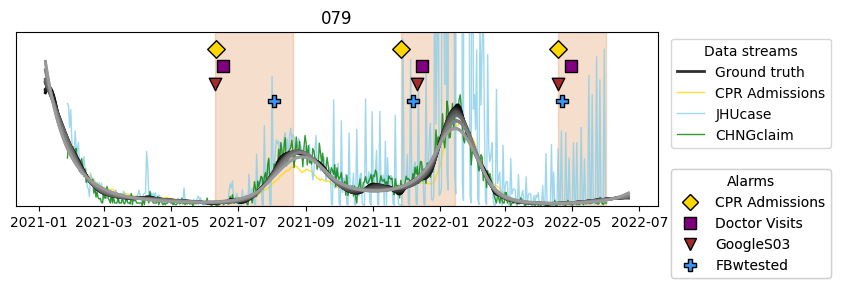

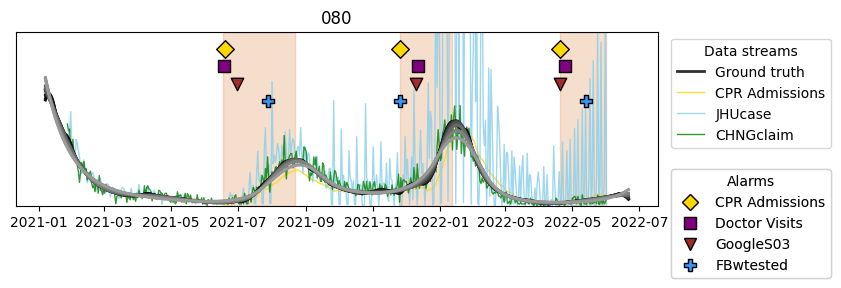

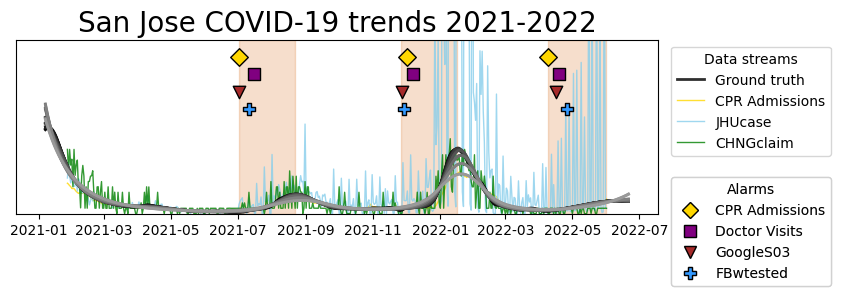

In [40]:

# "06037","023","Los Angeles CA","CA- ORANGE CO.",9445,0.001 
# "06037","056","Los Angeles CA","CA- LOS ANGELES",9771291,0.995 
# "06037","096","Los Angeles CA","CA- VENTURA",37869,0.004 

date_ref = pd.read_csv(f'dataFU/CPRadmission/CA_HRR.csv', index_col=0)
date_ref.index = pd.to_datetime(date_ref.index, format='%Y-%m-%d')
date_seq = date_ref.index
len(date_seq)
warnings.filterwarnings('ignore')
cnt_thr = 20
trim_length = 20
gt_thr = 0.

ref_names = ['CPRadmission', 'JHUcase', 'CHNGclaim']
ref_dfs = [pd.read_csv(f'dataFU/{data_name}/CA_HRR.csv', index_col=0) for data_name in ref_names]
for d_idx in range(len(ref_names)):
    ref_dfs[d_idx].index = pd.to_datetime(ref_dfs[d_idx].index, format='%Y-%m-%d')
    ref_dfs[d_idx] = ref_dfs[d_idx].loc[date_seq]
    print(ref_names[d_idx], ref_dfs[d_idx].index[0], ref_dfs[d_idx].index[-1])

noise_models = [['LogNormal', 'LogNormal', 'Poisson'], ['LogNormal', 'LogNormal', 'Poisson']]
penalty_values = [30, 100, 300, 1000, 3000, 10000, 30000]
zero_options = [['plus_one', 'plus_one', None], ['impute', 'impute', None]]
correction_indicators = [False, True, True]
for hrr_code in ref_dfs[0].columns:
    plot_gt(first_exceedance_times_dict, ref_dfs, hrr_code, ref_names, date_seq, trim_length, gt_thr, cnt_thr, penalty_values, noise_models, zero_options, correction_indicators, interval_threshold = 14)

CPRadmission 2021-01-07 00:00:00 2022-06-21 00:00:00
JHUcase 2021-01-07 00:00:00 2022-06-21 00:00:00
CHNGclaim 2021-01-07 00:00:00 2022-06-21 00:00:00


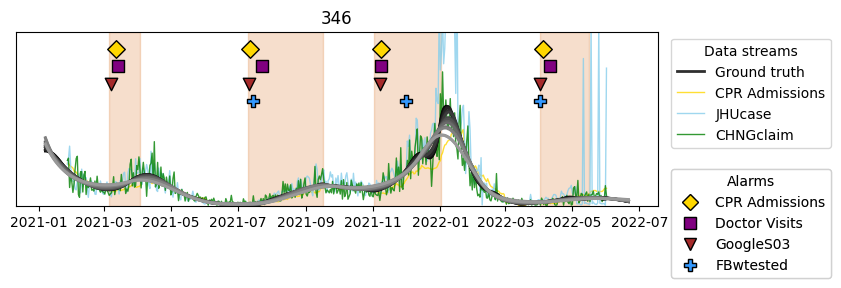

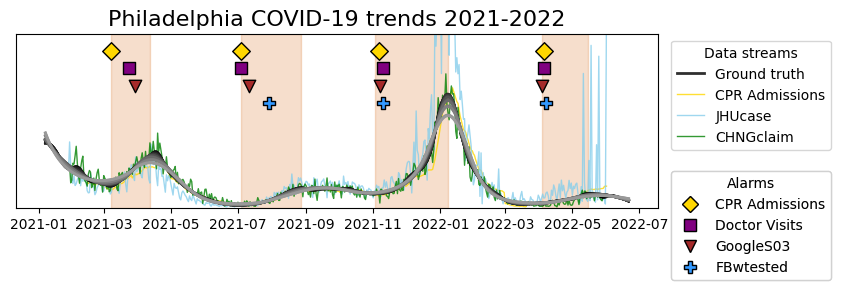

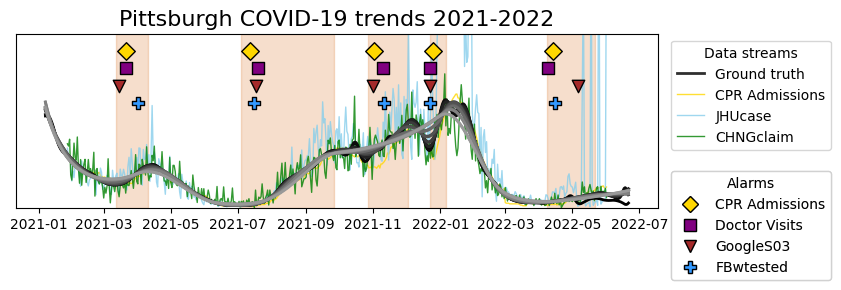

In [41]:
# "42003","357","Allegheny PA","PA- PITTSBURGH",1223348,1 

date_ref = pd.read_csv(f'dataFU/CPRadmission/PA_HRR.csv', index_col=0)
date_ref.index = pd.to_datetime(date_ref.index, format='%Y-%m-%d')
date_seq = date_ref.index
len(date_seq)
warnings.filterwarnings('ignore')
cnt_thr = 20
trim_length = 20
gt_thr = 0.

ref_names = ['CPRadmission', 'JHUcase', 'CHNGclaim']
ref_dfs = [pd.read_csv(f'dataFU/{data_name}/PA_HRR.csv', index_col=0) for data_name in ref_names]
for d_idx in range(len(ref_names)):
    ref_dfs[d_idx].index = pd.to_datetime(ref_dfs[d_idx].index, format='%Y-%m-%d')
    ref_dfs[d_idx] = ref_dfs[d_idx].loc[date_seq]
    print(ref_names[d_idx], ref_dfs[d_idx].index[0], ref_dfs[d_idx].index[-1])

noise_models = [['LogNormal', 'LogNormal', 'Poisson'], ['LogNormal', 'LogNormal', 'Poisson']]
penalty_values = [30, 100, 300, 1000, 3000, 10000, 30000]
zero_options = [['plus_one', 'plus_one', None], ['impute', 'impute', None]]
correction_indicators = [False, True, True]
for hrr_code in ref_dfs[0].columns:
    plot_gt(first_exceedance_times_dict, ref_dfs, hrr_code, ref_names, date_seq, trim_length, gt_thr, cnt_thr, penalty_values, noise_models, zero_options, correction_indicators, interval_threshold = 14)

CPRadmission 2021-01-07 00:00:00 2022-06-21 00:00:00
JHUcase 2021-01-07 00:00:00 2022-06-21 00:00:00
CHNGclaim 2021-01-07 00:00:00 2022-06-21 00:00:00


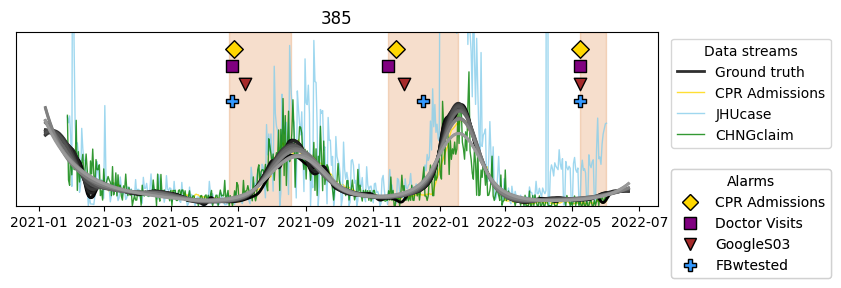

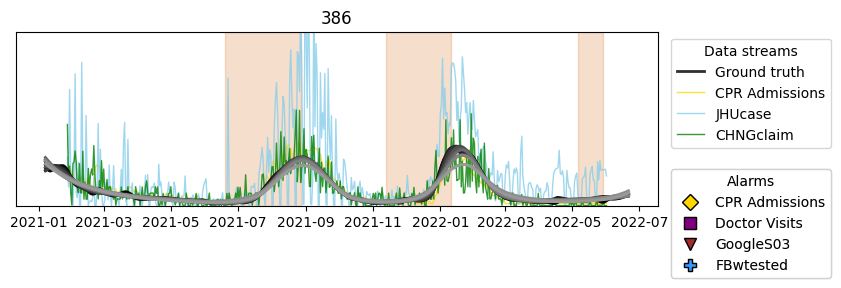

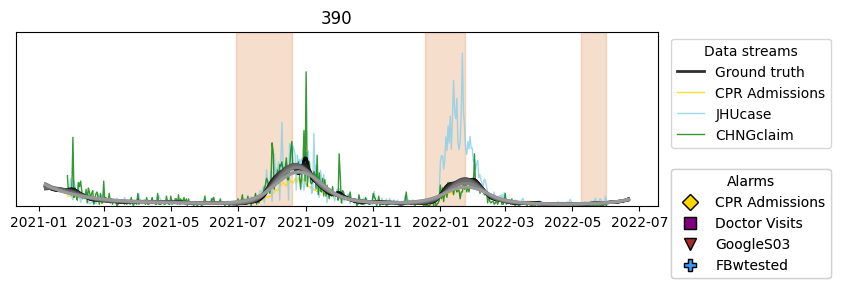

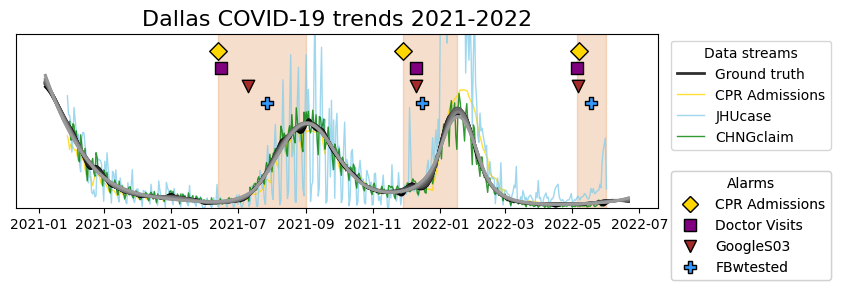

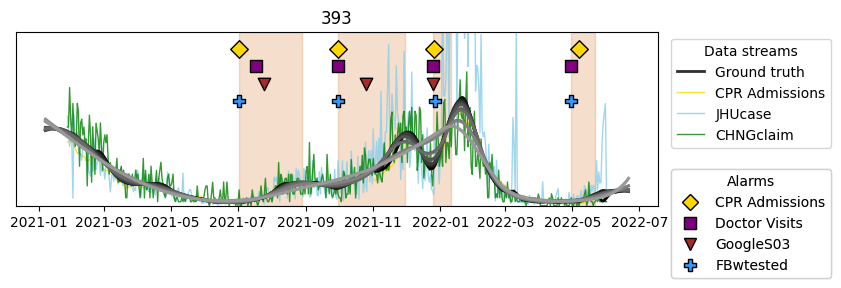

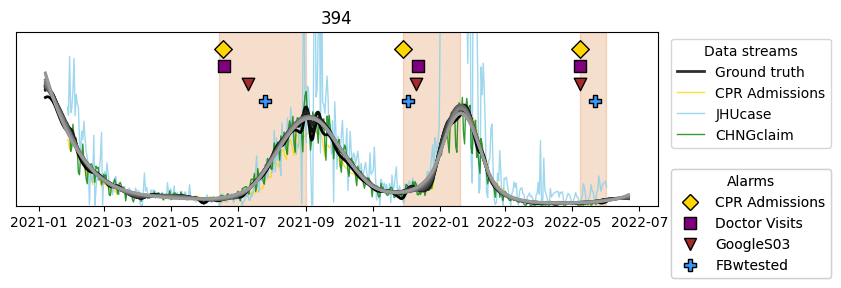

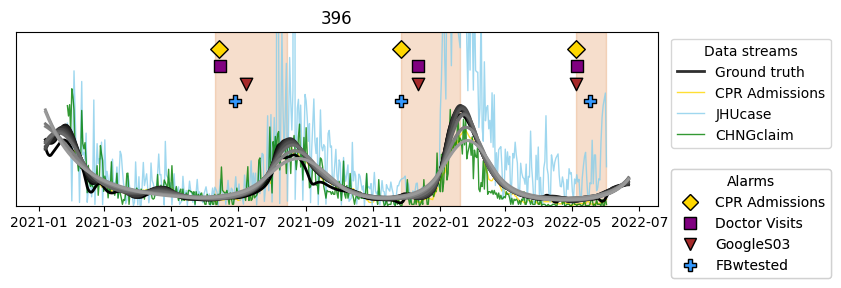

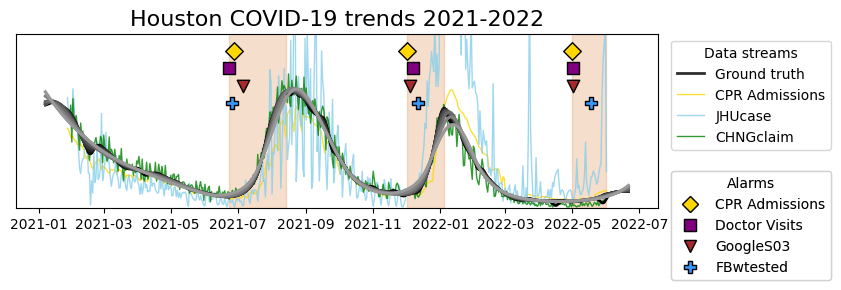

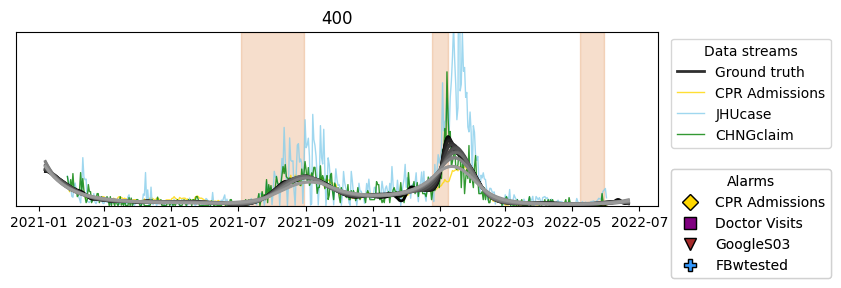

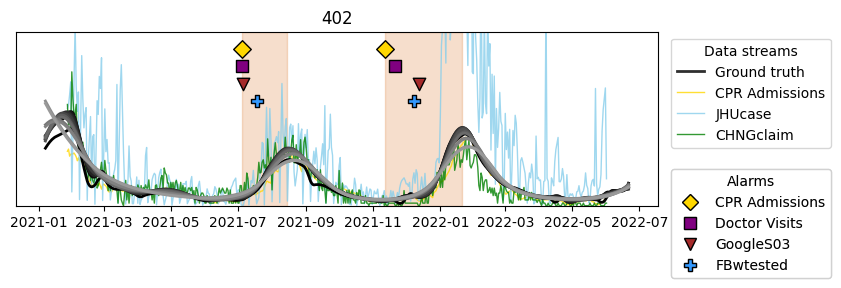

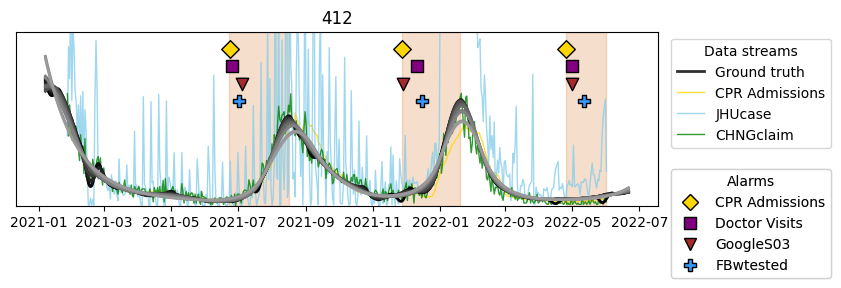

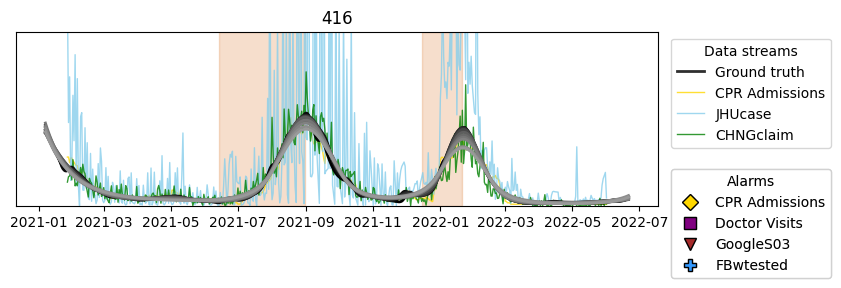

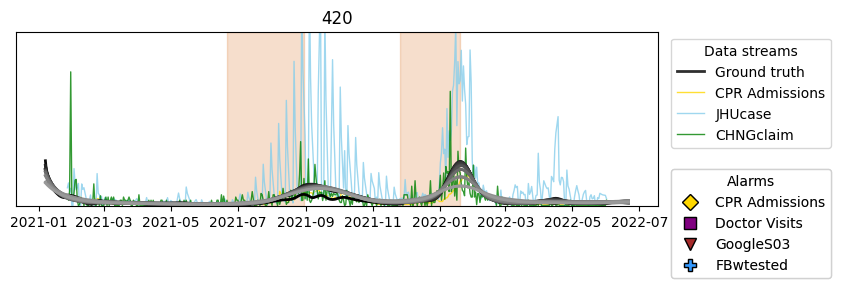

In [42]:
# "48015","397","Austin TX","TX- HOUSTON",28417,1 

date_ref = pd.read_csv(f'dataFU/CPRadmission/TX_HRR.csv', index_col=0)
date_ref.index = pd.to_datetime(date_ref.index, format='%Y-%m-%d')
date_seq = date_ref.index
len(date_seq)
warnings.filterwarnings('ignore')
cnt_thr = 20
trim_length = 20
gt_thr = 0.

ref_names = ['CPRadmission', 'JHUcase', 'CHNGclaim']
ref_dfs = [pd.read_csv(f'dataFU/{data_name}/TX_HRR.csv', index_col=0) for data_name in ref_names]
for d_idx in range(len(ref_names)):
    ref_dfs[d_idx].index = pd.to_datetime(ref_dfs[d_idx].index, format='%Y-%m-%d')
    ref_dfs[d_idx] = ref_dfs[d_idx].loc[date_seq]
    print(ref_names[d_idx], ref_dfs[d_idx].index[0], ref_dfs[d_idx].index[-1])

noise_models = [['LogNormal', 'LogNormal', 'Poisson'], ['LogNormal', 'LogNormal', 'Poisson']]
penalty_values = [30, 100, 300, 1000, 3000, 10000, 30000]
zero_options = [['plus_one', 'plus_one', None], ['impute', 'impute', None]]
correction_indicators = [False, True, True]
for hrr_code in ref_dfs[0].columns:
    plot_gt(first_exceedance_times_dict, ref_dfs, hrr_code, ref_names, date_seq, trim_length, gt_thr, cnt_thr, penalty_values, noise_models, zero_options, correction_indicators, interval_threshold = 14)

CPRadmission 2021-01-07 00:00:00 2022-06-21 00:00:00
JHUcase 2021-01-07 00:00:00 2022-06-21 00:00:00
CHNGclaim 2021-01-07 00:00:00 2022-06-21 00:00:00


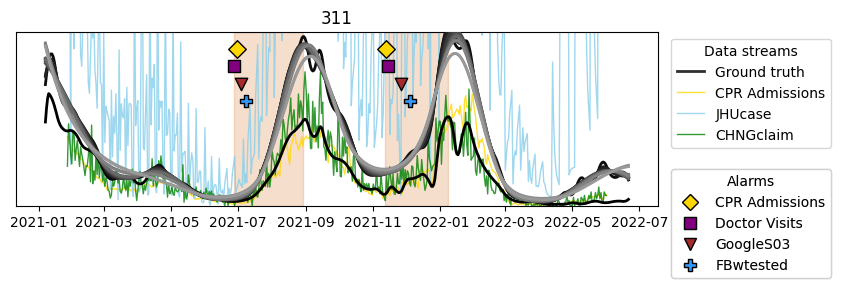

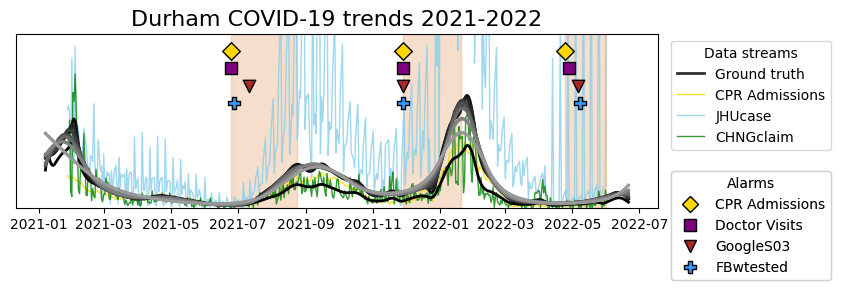

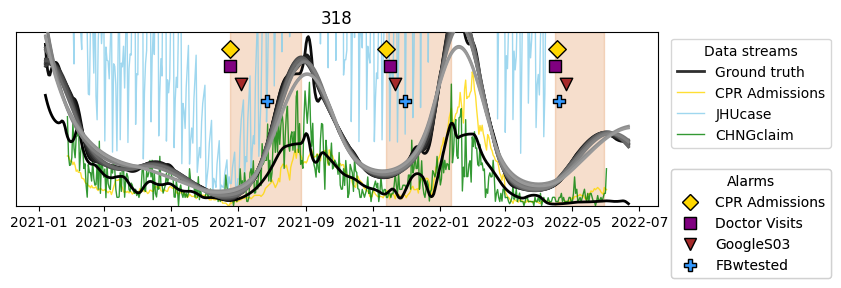

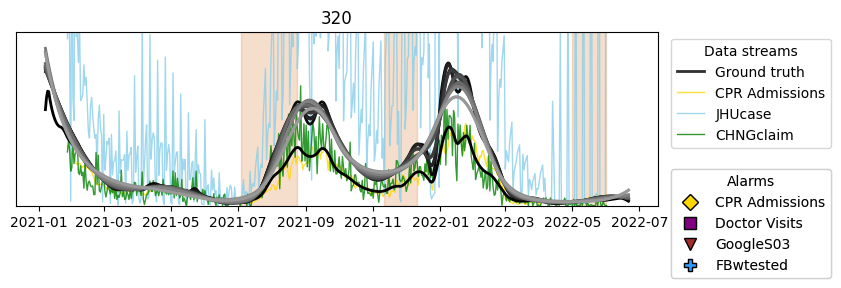

In [51]:
# "53033","437","King WA","WA- EVERETT",627,0 
# "53033","439","King WA","WA- SEATTLE",1929616,0.999 
# "53033","441","King WA","WA- TACOMA",1006,0.001 

date_ref = pd.read_csv(f'dataFU/CPRadmission/NC_HRR.csv', index_col=0)
date_ref.index = pd.to_datetime(date_ref.index, format='%Y-%m-%d')
date_seq = date_ref.index
len(date_seq)
warnings.filterwarnings('ignore')
cnt_thr = 20
trim_length = 20
gt_thr = 0.

ref_names = ['CPRadmission', 'JHUcase', 'CHNGclaim']
ref_dfs = [pd.read_csv(f'dataFU/{data_name}/NC_HRR.csv', index_col=0) for data_name in ref_names]
for d_idx in range(len(ref_names)):
    ref_dfs[d_idx].index = pd.to_datetime(ref_dfs[d_idx].index, format='%Y-%m-%d')
    ref_dfs[d_idx] = ref_dfs[d_idx].loc[date_seq]
    print(ref_names[d_idx], ref_dfs[d_idx].index[0], ref_dfs[d_idx].index[-1])

noise_models = [['LogNormal', 'LogNormal', 'Poisson'], ['LogNormal', 'LogNormal', 'Poisson']]
penalty_values = [30, 100, 300, 1000, 3000, 10000, 30000]
zero_options = [['plus_one', 'plus_one', None], ['impute', 'impute', None]]
correction_indicators = [False, True, True]
for hrr_code in ref_dfs[0].columns:
    plot_gt(first_exceedance_times_dict, ref_dfs, hrr_code, ref_names, date_seq, trim_length, gt_thr, cnt_thr, penalty_values, noise_models, zero_options, correction_indicators, interval_threshold = 14)

CPRadmission 2021-01-07 00:00:00 2022-06-21 00:00:00
JHUcase 2021-01-07 00:00:00 2022-06-21 00:00:00
CHNGclaim 2021-01-07 00:00:00 2022-06-21 00:00:00


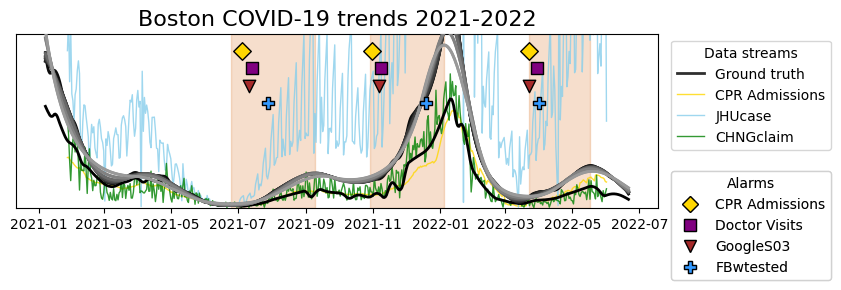

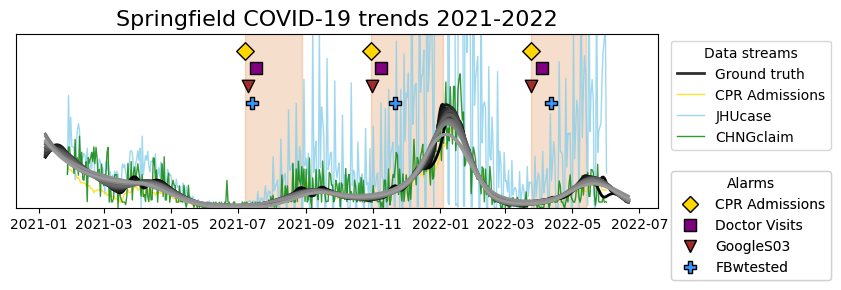

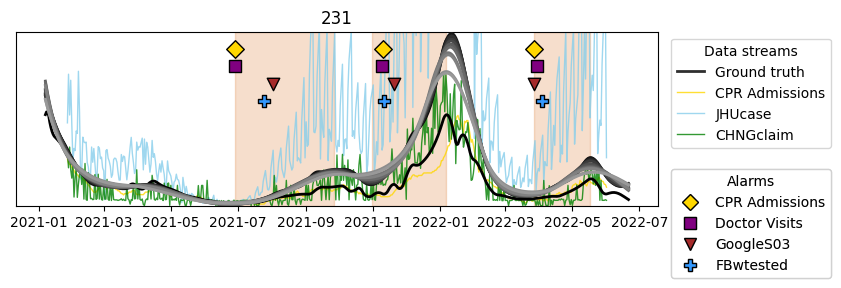

In [54]:
# "227", "MA- BOSTON"
date_ref = pd.read_csv(f'dataFU/CPRadmission/MA_HRR.csv', index_col=0)
date_ref.index = pd.to_datetime(date_ref.index, format='%Y-%m-%d')
date_seq = date_ref.index
len(date_seq)
warnings.filterwarnings('ignore')
cnt_thr = 20
trim_length = 20
gt_thr = 0.

ref_names = ['CPRadmission', 'JHUcase', 'CHNGclaim']
ref_dfs = [pd.read_csv(f'dataFU/{data_name}/MA_HRR.csv', index_col=0) for data_name in ref_names]
for d_idx in range(len(ref_names)):
    ref_dfs[d_idx].index = pd.to_datetime(ref_dfs[d_idx].index, format='%Y-%m-%d')
    ref_dfs[d_idx] = ref_dfs[d_idx].loc[date_seq]
    print(ref_names[d_idx], ref_dfs[d_idx].index[0], ref_dfs[d_idx].index[-1])

noise_models = [['LogNormal', 'LogNormal', 'Poisson'], ['LogNormal', 'LogNormal', 'Poisson']]
penalty_values = [30, 100, 300, 1000, 3000, 10000, 30000]
zero_options = [['plus_one', 'plus_one', None], ['impute', 'impute', None]]
correction_indicators = [False, True, True]
for hrr_code in ref_dfs[0].columns:
    plot_gt(first_exceedance_times_dict, ref_dfs, hrr_code, ref_names, date_seq, trim_length, gt_thr, cnt_thr, penalty_values, noise_models, zero_options, correction_indicators, interval_threshold = 14)

CPRadmission 2021-01-07 00:00:00 2022-06-21 00:00:00
JHUcase 2021-01-07 00:00:00 2022-06-21 00:00:00
CHNGclaim 2021-01-07 00:00:00 2022-06-21 00:00:00


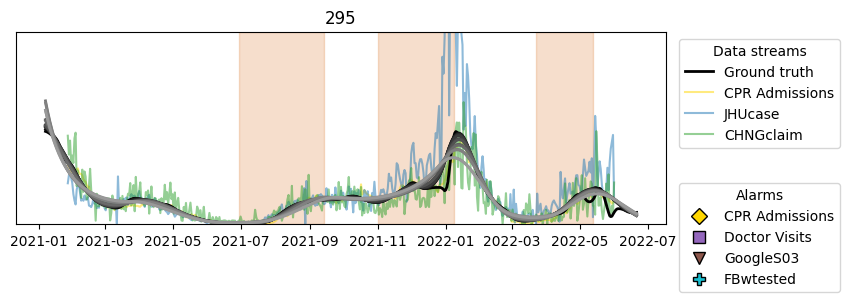

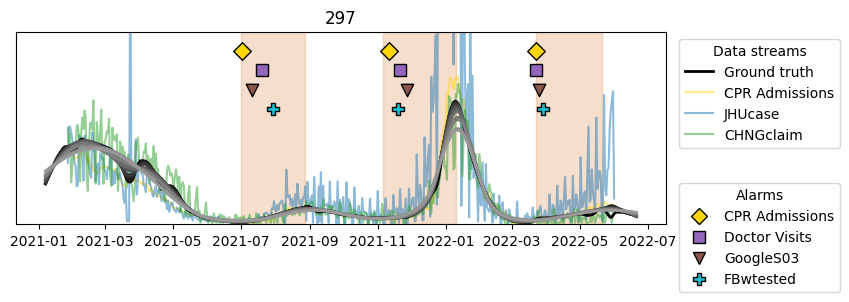

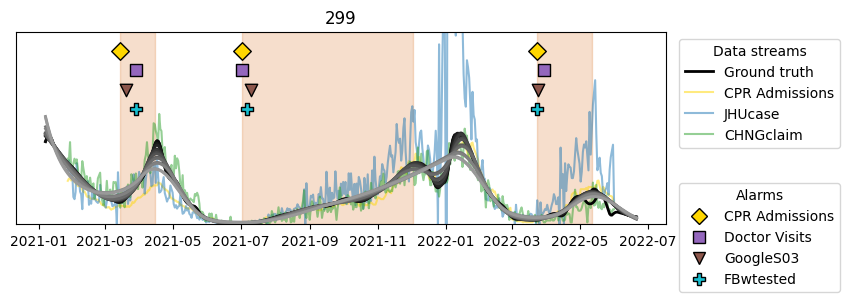

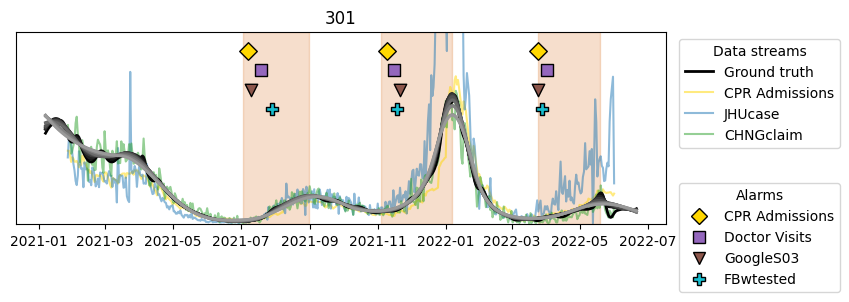

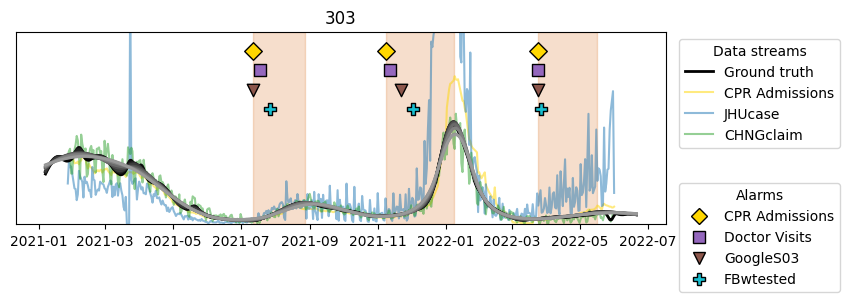

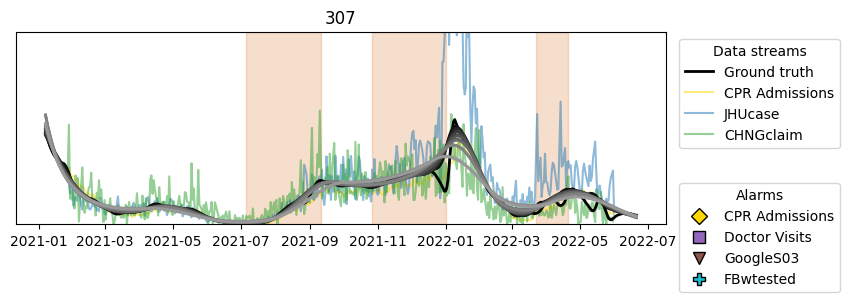

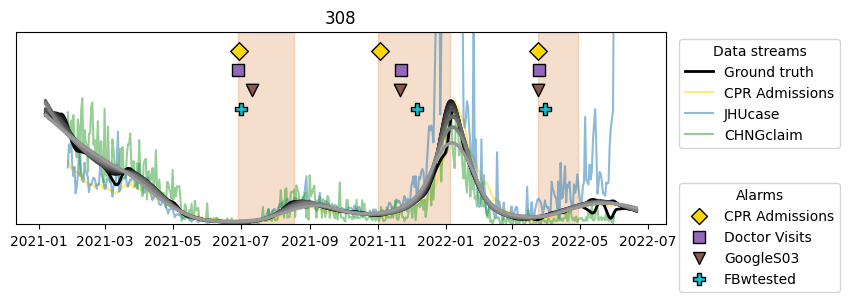

In [162]:
# "227", "MA- BOSTON"
date_ref = pd.read_csv(f'data/CPRadmission/NY_HRR.csv', index_col=0)
date_ref.index = pd.to_datetime(date_ref.index, format='%Y-%m-%d')
date_seq = date_ref.index
len(date_seq)
warnings.filterwarnings('ignore')
cnt_thr = 20
trim_length = 20
gt_thr = 0.

ref_names = ['CPRadmission', 'JHUcase', 'CHNGclaim']
ref_dfs = [pd.read_csv(f'data/{data_name}/NY_HRR.csv', index_col=0) for data_name in ref_names]
for d_idx in range(len(ref_names)):
    ref_dfs[d_idx].index = pd.to_datetime(ref_dfs[d_idx].index, format='%Y-%m-%d')
    ref_dfs[d_idx] = ref_dfs[d_idx].loc[date_seq]
    print(ref_names[d_idx], ref_dfs[d_idx].index[0], ref_dfs[d_idx].index[-1])

noise_models = [['LogNormal', 'LogNormal', 'Poisson'], ['LogNormal', 'LogNormal', 'Poisson']]
penalty_values = [30, 100, 300, 1000, 3000, 10000, 30000]
zero_options = [['plus_one', 'plus_one', None], ['impute', 'impute', None]]
correction_indicators = [False, True, True]
for hrr_code in ref_dfs[0].columns:
    plot_gt(first_exceedance_times_dict, ref_dfs, hrr_code, ref_names, date_seq, trim_length, gt_thr, cnt_thr, penalty_values, noise_models, zero_options, correction_indicators, interval_threshold = 14)